In [ ]:



# !apt-get update -y
!apt-get --purge remove "*cublas*" "cuda*" "nsight*"
!nvcc --version

!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
!mv cuda-ubuntu1804.pin /etc/apt/preferences.d/cuda-repository-pin-600
!wget https://developer.download.nvidia.com/compute/cuda/10.2/Prod/local_installers/cuda-repo-ubuntu1804-10-2-local-10.2.89-440.33.01_1.0-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1804-10-2-local-10.2.89-440.33.01_1.0-1_amd64.deb
!apt-key add /var/cuda-repo-10-2-local-10.2.89-440.33.01/7fa2af80.pub
# !apt-get update
!apt-get -y install cuda


! nvidia-smi
! git clone https://github.com/microsoft/GLIP.git
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

import os
os.chdir('GLIP')
! git checkout c663d9db8a503e04c6b76cd2e14152bab775d28a
! pip install torch==1.9.0 torchvision  torchaudio
! pip install einops shapely timm yacs tensorboardX ftfy prettytable pymongo
! pip install transformers
! python setup.py build develop --user
! mkdir MODEL




# Load image from URL




In [ ]:
!gdown 1JwQfGe-k-COzK0-QogLxcMS_1TVFKEkf
# https://drive.google.com/file/d/1JwQfGe-k-COzK0-QogLxcMS_1TVFKEkf/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1JwQfGe-k-COzK0-QogLxcMS_1TVFKEkf
To: /content/data.zip
100% 937M/937M [00:14<00:00, 66.1MB/s]


In [ ]:
import os
!unzip -qq data.zip


for i in ['over-served', 'tasted', 'eaten', 'untouched']:
  directory = "data/" + i

  # Loop over all files in the directory
  for filename in os.listdir(directory):
      # Check if the file is a .DS_Store file
      if filename.endswith(".DS_Store"):
          # If it is, delete the file
          os.remove(os.path.join(directory, filename))

In [ ]:


import os, json, pickle, random
import torch.utils.data
from PIL import Image
import torchvision
from torchvision import transforms


class RiceImages(torch.utils.data.Dataset):

  # Initialize the class e.g. load files, preprocess, etc.
  def __init__(self,  transform = None):
    # These are the 20 categories selected.
    self.categories = open('data' + '/ClassName.txt').read().split('\n')[:-1]
    self.categories = sorted(self.categories)
    self.category2index = {category: idx for (idx, category) in enumerate(self.categories)}
    self.transform = transform

    # Compile a list of images and corresponding labels.
    self.imagepaths = []
    self.labels = []
    for category in self.categories:
      category_directory = 'data/'  + category
      category_imagenames = os.listdir(category_directory)
      self.imagepaths += [os.path.join(category_directory, imagename)
                          for imagename in category_imagenames]
      self.labels += [self.category2index[category]] * len(category_imagenames)

    # Sort imagepaths alphabetically and labels accordingly.
    sorted_pairs = sorted(zip(self.imagepaths, self.labels), key = lambda x: x[0])
    self.imagepaths, self.labels = zip(*sorted_pairs)


  # Return a sample (x, y) as a tuple e.g. (image, label)
  def __getitem__(self, index):
    image = Image.open(self.imagepaths[index]).convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image, self.labels[index]

  # Return the total number of samples.
  def __len__(self):
    return len(self.imagepaths)



In [ ]:
# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the dataset
dataset = RiceImages(transform=transform)

# Calculate the size of the train and test sets based on an 80/20 split
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size

# Split the dataset into train and test sets
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])

# Create data loaders for the train and test sets
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)


In [ ]:
!pip install livelossplot --quiet


In [ ]:
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
import matplotlib.pyplot as plt

# Defining as global the device to use (by default CPU).
# device = torch.device("cuda")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(batch_size,
                n_epochs,
                learningRate,
                model,
                cost_function,
                optimizer,
                scheduler,
                train_loader,
                val_loader):

  # Move the model and cost function to GPU (if needed).
  model = model.to(device)
  cost_function.zero_grad()
  cost_function = cost_function.to(device)

  # Keep track of best accuracy so far.
  best_accuracy = 0
  liveloss = PlotLosses()
  optimizer.zero_grad()
  fig = plt.gcf()

  # Main for loop of SGD.
  for epoch in range(0, n_epochs):
    logs = {}

    # initialize control variables.
    correct = 0
    cumulative_loss = 0
    n_samples = 0

    # Set the model in training mode.
    model.train()

    # Sample a batch on each iteration.
    for (batch_id, (xb, yb)) in enumerate(train_loader):
      model.zero_grad()

      # Move (x,y) data to GPU (if so desired).
      xb = xb.to(device)
      yb = yb.to(device)

      # Compute predictions.
      predicted = model(xb)
      # print(xb.shape, yb.shape, predicted.shape)

      # Compute loss.
      loss = cost_function(predicted, yb)
      cumulative_loss += loss.item()

      # Count how many correct in batch.
      predicted_ = predicted.detach().softmax(dim = 1)
      max_vals, max_ids = predicted_.max(dim = 1)
      correct += (max_ids == yb).sum().cpu().item()
      n_samples += xb.size(0)

      # Compute gradients (autograd).
      loss.backward()

      # Run one basic training step of SGD.
      optimizer.step()
      # This does basically the following operation.
      # for param in model.parameters():
      #    param.data -= learningRate * param.grad.data

      # Keep track of loss and accuracy for the plot.
      n_batches = 1 + batch_id
      logs['loss'] = cumulative_loss / n_batches
      logs['accuracy'] = correct / n_samples
      # liveloss.update(logs)
      # liveloss.send()
      # liveloss.save('loss_plot.pdf', bbox_inches='tight')

    # initialize control variables.
    correct = 0
    cumulative_loss = 0
    n_samples = 0

    # Set the model in evaluation mode.
    model.eval()

    # No need to keep track of gradients for this part.
    with torch.no_grad():
      # Run the model on the validation set to keep track of accuracy there.
      for (batch_id, (xb, yb)) in enumerate(val_loader):

        # Move data to GPU if needed.
        xb = xb.to(device)
        yb = yb.to(device)

        # Compute predictions.
        predicted = model(xb)

        # Compute loss.
        loss = cost_function(predicted, yb)
        cumulative_loss += loss.item()

        # Count how many correct in batch.
        predicted_ = predicted.detach().softmax(dim = 1)
        max_vals, max_ids = predicted_.max(dim = 1)
        correct += (max_ids == yb).sum().cpu().item()
        n_samples += xb.size(0)

        # Keep track of loss and accuracy for the plot.
        n_batches = 1 + batch_id
        logs['val_loss'] = cumulative_loss / n_batches
        logs['val_accuracy'] = correct / n_samples

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth')

    # Update the plot with new logging information.
    liveloss.update(logs)
    liveloss.send()
    # liveloss.save('loss_plot.pdf', bbox_inches='tight')

    # What is this for? Please look it up.
    if scheduler != -1:
        scheduler.step()

  # Load the model parameters for the one that achieved the best val accuracy.
  # model.load_state_dict(torch.load('best_model_so_far.pth'))

In [ ]:
import torchvision.models as models
# from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import transforms
import torch.nn as nn

class TransformerCNN(nn.Module):
    def __init__(self, num_classes):
        super(TransformerCNN, self).__init__()
        # self.weights = models.ResNet50_Weights.DEFAULT
        # self.dim_feedforward = 2048
        self.model = models.resnet50(pretrained=True)
        self.fc1 = nn.Linear(1000, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=512, nhead=4)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer, num_layers=1)

    def forward(self, x):
        x = self.model(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = x.unsqueeze(1)  # Add a sequence length dimension
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global average pooling over the sequence length dimension
        x = self.fc2(x)
        return x



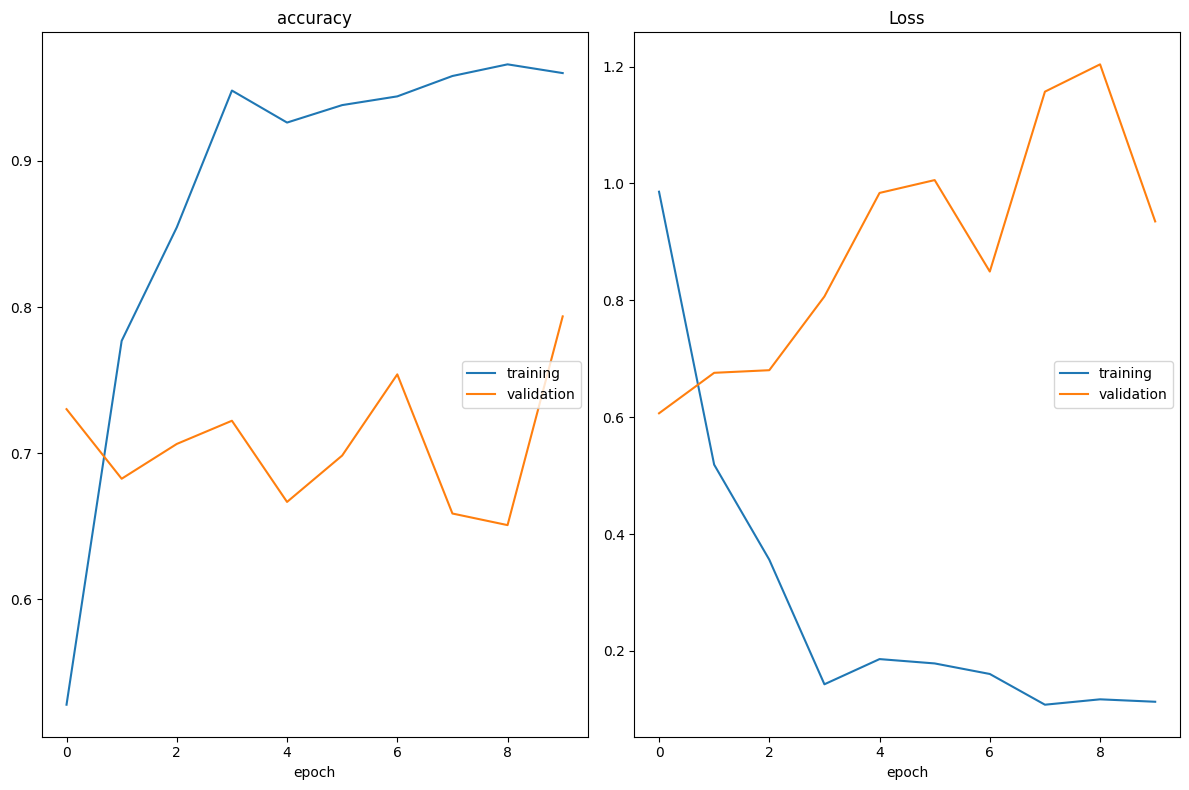

accuracy
	training         	 (min:    0.528, max:    0.966, cur:    0.960)
	validation       	 (min:    0.651, max:    0.794, cur:    0.794)
Loss
	training         	 (min:    0.108, max:    0.986, cur:    0.113)
	validation       	 (min:    0.607, max:    1.204, cur:    0.935)


In [ ]:
#transformer with cnn using resnet50

model_trans = TransformerCNN(4)
model_trans.train()




batch_size = 128
n_epochs = 10
learningRate = 1e-4



cost_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_trans.parameters(), lr = learningRate)


train_model(batch_size, n_epochs, learningRate,
            model_trans, cost_function, optimizer, -1,
            train_dataloader, validation_dataloader);


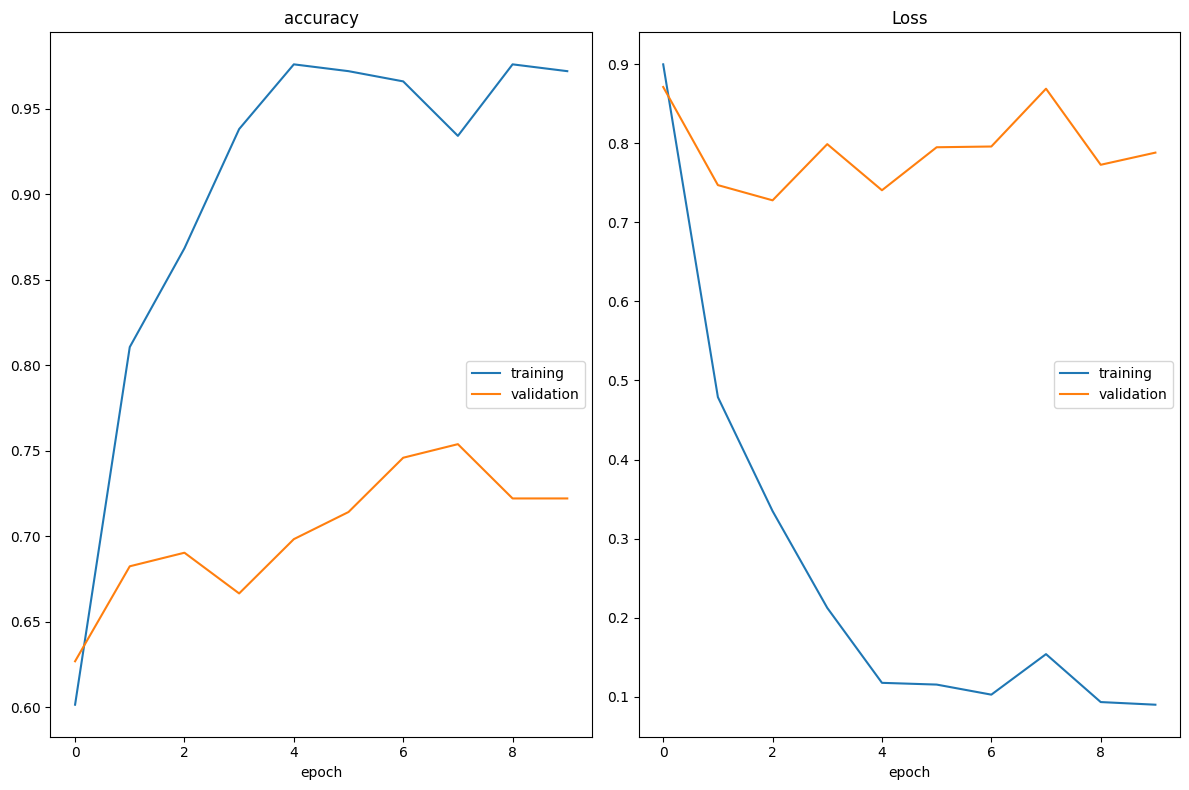

accuracy
	training         	 (min:    0.602, max:    0.976, cur:    0.972)
	validation       	 (min:    0.627, max:    0.754, cur:    0.722)
Loss
	training         	 (min:    0.090, max:    0.900, cur:    0.090)
	validation       	 (min:    0.728, max:    0.871, cur:    0.788)


In [ ]:
#model trained only using resnet50

from torchvision.models import resnet50
model_cnn = resnet50(pretrained=True)
model_cnn.fc = torch.nn.Sequential(torch.nn.Linear(2048,4))

batch_size = 64
n_epochs = 10
learningRate = 1e-4



cost_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_cnn.parameters(), lr = learningRate)




train_model(batch_size, n_epochs, learningRate,
            model_cnn, cost_function, optimizer, -1,
            train_dataloader, validation_dataloader);

In [ ]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np

url = 'https://static.independent.co.uk/s3fs-public/thumbnails/image/2017/10/31/08/istock-522752535.jpg?quality=75&width=1200&auto=webp'


def load(url):
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  return image

def load_numpy(url):
    pil_image= load(url)
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image


def imshow(img, caption):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    plt.figtext(0.5, 0.09, caption, wrap=True, horizontalalignment='center', fontsize=20)

4


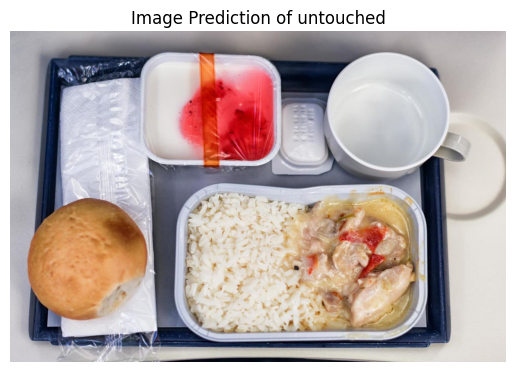

P("eaten") = 0.00
P("over-served") = 0.43
P("tasted") = 0.04
P("untouched") = 0.53


In [ ]:
import matplotlib.pyplot as plt

input_image_id = 27
model_trans.eval()

# Load the validation set in case not loaded.
dataset = RiceImages()

# Calculate the size of the train and test sets based on an 80/20 split
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size

# Split the dataset into train and validation sets
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])

# valset = SUN20(split = 'val')

# Sample

x,y = load(url).convert('RGB'), 3

# Process input and add a dummy batch dimension.
xp = transform(x)[None, :].to(device)

predictions = model_trans(xp).softmax(dim = 1)

print(len(predictions[0]))

plt.figure();plt.title(f"Image Prediction of {validation_dataset.dataset.categories[y]}");plt.imshow(x);plt.axis(False);plt.show();

# Show predictions from this model.
for i in range(0, len(validation_dataset.dataset.categories)):
  score = predictions[0, i].item()
  category = validation_dataset.dataset.categories[i]
  print('P("{0}") = {1:.2f}'.format(category, score))

In [ ]:
validation_dataset.dataset.category2index

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.engine.predictor_glip import GLIPDemo

! wget https://penzhanwu2bbs.blob.core.windows.net/data/GLIPv1_Open/models/glip_tiny_model_o365_goldg_cc_sbu.pth -O MODEL/glip_tiny_model_o365_goldg_cc_sbu.pth

pylab.rcParams['figure.figsize'] = 20, 12



# Use this command for evaluate the GLPT-T model
config_file = "configs/pretrain/glip_Swin_T_O365_GoldG.yaml"
weight_file = "MODEL/glip_tiny_model_o365_goldg_cc_sbu.pth"

# Use this command to evaluate the GLPT-L model
# ! wget https://penzhanwu2bbs.blob.core.windows.net/data/GLIPv1_Open/models/glip_large_model.pth -O MODEL/glip_large_model.pth
# config_file = "configs/pretrain/glip_Swin_L.yaml"
# weight_file = "MODEL/glip_large_model.pth"

# update the config options with the config file
# manual override some options
cfg.local_rank = 0
cfg.num_gpus = 1
cfg.merge_from_file(config_file)
cfg.merge_from_list(["MODEL.WEIGHT", weight_file])
cfg.merge_from_list(["MODEL.DEVICE", "cuda"])

glip_demo = GLIPDemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
    show_mask_heatmaps=False
)

In [ ]:
import requests
from io import BytesIO
from PIL import Image

# test_dataset = TestDataset()

# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

image = load_numpy(url)
caption = 'rice. noodles. bread. dessert'
result, top_pred = glip_demo.run_on_web_image(image, caption, 0.65)
imshow(result, caption)


image = load(url)
# Define crop coordinates as a tuple of (left, upper, right, lower) values
 # Example crop dimensions
for bbox in top_pred.bbox:
    xmin, ymin, xmax, ymax = bbox.tolist()
    crop_coords = (xmin, ymin, xmax, ymax)
    cropped_image = image.crop(crop_coords)
    # cropped_image.show()
    x,y = cropped_image.convert('RGB'), 3

# Process input and add a dummy batch dimension.
    xp = transform(x)[None, :].to(device)

    predictions = model_trans(xp).softmax(dim = 1)

    print(len(predictions[0]))

    plt.figure();plt.title(f"Image Prediction of {validation_dataset.dataset.categories[y]}");plt.imshow(x);plt.axis(False);plt.show();

    # Show predictions from this model.
    for i in range(0, len(validation_dataset.dataset.categories)):
      score = predictions[0, i].item()
      category = validation_dataset.dataset.categories[i]
      print('P("{0}") = {1:.2f}'.format(category, score))

In [ ]:
!gdown 1fQT4T6uhZl_VQf_HVhqXwyuzXdDoPFbN
!unzip -qq data-test.zip
!pip install transformers -qq


Downloading...
From: https://drive.google.com/uc?id=1fQT4T6uhZl_VQf_HVhqXwyuzXdDoPFbN
To: /content/data-test.zip
100% 102M/102M [00:01<00:00, 55.6MB/s] 
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 1.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
df = pd.read_csv('data-test/test_images.csv')
img_name = df.iloc[0, 0]
print(img_name)

1


In [ ]:
import os
from PIL import Image
import pandas as pd
import torch
from torch.utils.data import Dataset

class TestDataset(Dataset):
    def __init__(self, csv_file='data-test/test_images.csv', transform=None):
        self.df = pd.read_csv(csv_file)

        self.transform = transform
        self.datalabels = {'eaten':0,'over-served':1,'tasted':2,'untouched':3}

    def __len__(self):
        return len(self.menu_df)

    def __getitem__(self, index):
        # get the image name and labels at the specified index
        img_name = self.df.iloc[index, 0]
        rice_label = self.datalabels[self.df.iloc[index, 1]]
        salad_label = self.datalabels[self.df.iloc[index, 2]]
        dessert_label = self.datalabels[self.df.iloc[index, 3]]
        bread_label = self.datalabels[self.df.iloc[index, 4]]

        # load the image
        # print(img_name)
        image = Image.open('data-test/images/'+str(img_name)+'.jpg')

        # apply the optional transform if provided
        if self.transform is not None:
            image = self.transform(image)

        # convert the labels to PyTorch tensors
        label_tensor = torch.tensor([rice_label, salad_label, dessert_label, bread_label], dtype=torch.float32)

        return image, label_tensor

In [ ]:
coco_names = ["person" , "bicycle" , "car" , "motorcycle" , "airplane" , "bus" , "train" , "truck" , "boat" , "traffic light" , "fire hydrant" , "street sign" , "stop sign" , "parking meter" , "bench" , "bird" , "cat" , "dog" , "horse" , "sheep" , "cow" , "elephant" , "bear" , "zebra" , "giraffe" , "hat" , "backpack" , "umbrella" , "shoe" , "eye glasses" , "handbag" , "tie" , "suitcase" ,
"frisbee" , "skis" , "snowboard" , "sports ball" , "kite" , "baseball bat" ,
"baseball glove" , "skateboard" , "surfboard" , "tennis racket" , "bottle" ,
"plate" , "wine glass" , "cup" , "fork" , "knife" , "spoon" , "bowl" ,
"banana" , "apple" , "sandwich" , "orange" , "broccoli" , "carrot" , "hot dog" ,
"pizza" , "donut" , "cake" , "chair" , "couch" , "potted plant" , "bed" ,
"mirror" , "dining table" , "window" , "desk" , "toilet" , "door" , "tv" ,
"laptop" , "mouse" , "remote" , "keyboard" , "cell phone" , "microwave" ,
"oven" , "toaster" , "sink" , "refrigerator" , "blender" , "book" ,
"clock" , "vase" , "scissors" , "teddy bear" , "hair drier" , "toothbrush" , "hair brush"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix

def test_model3(model, test_dataset, fastrcnn_model, batch_size=1):
    model.eval()
    fastrcnn_model.eval()
    model.to(device)

    accuracy = 0
    total_samples = 0
    predicted_labels = []
    true_labels = []

    for i, (image, labels) in enumerate(test_dataset):

        transform = T.ToTensor()
        img = transform(image)
        img.to(device)

        with torch.no_grad():
            pred = fastrcnn_model([img])

        boxes, labels, scores = pred[0]["boxes"], pred[0]["labels"], pred[0]["scores"]
        num = torch.argwhere(scores > 0.9).shape[0]
        font = cv2.FONT_HERSHEY_SIMPLEX

        for i in range(4):
            x1, y1, x2, y2 = boxes[i].numpy().astype("int")
            if labels.numpy()[i] - 1 == 50:
                crop_coords = (x1, y1, x2, y2)
                cropped_image = image.crop(crop_coords)
                category_label = test_dataset.df.iloc[i, i+1]
                category = test_dataset.datalabels[category_label]
                # print(category)
                x = cropped_image.convert('RGB')
                xp = transform(x)[None, :].to(device)

                with torch.no_grad():
                    outputs = model(xp)

                _, predicted = torch.max(outputs.data, 1)
                # predicted_category = test_dataset.datalabels[predicted.item()]
                for key, value in test_dataset.datalabels.items():
                    if value == predicted.item():
                        predicted_category = key
                        break
                predicted_labels.append(predicted_category)
                true_labels.append(category_label)

                if predicted.item() == category:
                    accuracy += 1
                    # print(accuracy)
                total_samples += 1
                # confusion = confusion_matrix(true_labels, predicted_labels, labels=list(test_dataset.datalabels.keys()))
                break


    overall_accuracy = accuracy / total_samples
    confusion = confusion_matrix(true_labels, predicted_labels, labels=['eaten','over-served','tasted','untouched'])

    return overall_accuracy, confusion


test_dataset = TestDataset()
fastrcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

acc, confusion = test_model3(model_trans, test_dataset, fastrcnn_model, batch_size=1)
print(acc)
print(confusion)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 59.7MB/s]


0.25296442687747034
[[ 0  0  0  0]
 [ 0  0  0  0]
 [16  8  0 24]
 [78 63  0 64]]


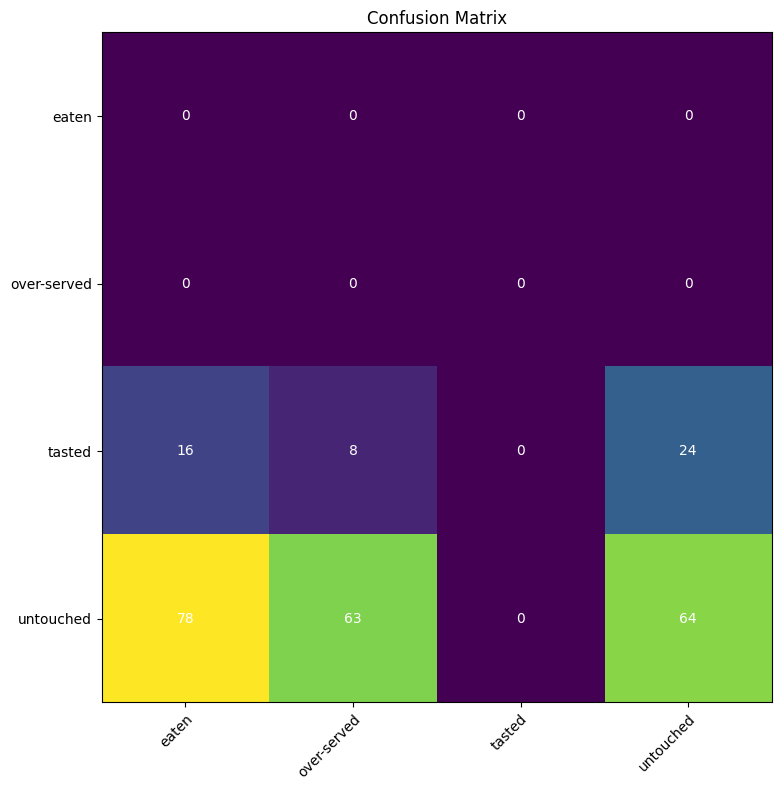

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

datalabels = test_dataset.datalabels
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(confusion)

# Add labels to the x-axis and y-axis
ax.set_xticks(np.arange(len(datalabels)))
ax.set_yticks(np.arange(len(datalabels)))
ax.set_xticklabels(list(datalabels.keys()))
ax.set_yticklabels(list(datalabels.keys()))

# Rotate the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over the data and add text annotations to the heatmap
for i in range(len(datalabels)):
    for j in range(len(datalabels)):
        ax.text(j, i, confusion[i, j], ha="center", va="center", color="w")

# Add a title and show the plot
ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.show()

In [ ]:
# YOLO Pre-training LINK
# https://colab.research.google.com/drive/1uFR_Vc_2ToiwjFlDenMlm-cQxlZFvzX3?usp=sharing

In [ ]:
# For GLIP

import torch
import torch.nn.functional as F
from PIL import Image
import pandas as pd
import numpy as np

test_dataset = RiceImages()

def test_model2(model, test_dataloader, batch_size=1, confidence_threshold=0.65):
    model.eval()

    # initialize the accuracy and total number of samples
    accuracy = 0
    total_samples = 0

    # loop over the batches in the dataloader
    for i, (images, labels) in enumerate(test_dataloader):
        # get the corresponding image name from the dataset
        img_name = test_dataset.df.iloc[i, 0]

        image = Image.open('data-test/images/'+str(img_name)+'.jpg')

        # process the image using the Glip demo function
        caption = 'rice. salad. dessert. bread'
        result, top_pred = glip_demo.run_on_web_image(image, caption, confidence_threshold)

        # loop over the predicted bounding boxes and labels
        for bbox, category in enumerate(zip(top_pred.bbox,top_pred.get_field('labels'))):
            xmin, ymin, xmax, ymax = bbox.tolist()
            crop_coords = (xmin, ymin, xmax, ymax)
            cropped_image = image.crop(crop_coords)
            category = test_dataset.df.iloc[i, category-1]
            # convert the cropped image to RGB and apply the transform
            x = cropped_image.convert('RGB')
            xp = transform(x)[None, :].to(device)

            # forward pass through the model
            with torch.no_grad():
                outputs = model(xp)

            # calculate the predicted label
            _, predicted = torch.max(outputs.data, 1)
            predicted_category = validation_dataset.dataset.categories[predicted]

            # calculate the accuracy and update the total number of samples
            accuracy += (predicted_category == category).item()
            total_samples += 1

    # calculate the overall accuracy
    overall_accuracy = accuracy / total_samples

    return overall_accuracy


(<PIL.Image.Image image mode=RGB size=1024x1024 at 0x7F323BB27A30>, 0)

In [ ]:
# Fater-RCNN Pre-trained prediction
# https://colab.research.google.com/drive/10ZOfo8rGu9ZGAc04_RH-t8Yc9PQdw1wB?usp=sharing